In [58]:
# Import modules
import os
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [36]:
# DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
# !wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
# Or ELse download from here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

--2022-07-14 12:39:11--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 2600:9000:23d1:aa00:b:20a5:b140:21, 2600:9000:23d1:6a00:b:20a5:b140:21, 2600:9000:23d1:3400:b:20a5:b140:21, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|2600:9000:23d1:aa00:b:20a5:b140:21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145679 (1.1M) [binary/octet-stream]
Saving to: 'green_tripdata_2021-02.parquet'

     0K .......... .......... .......... .......... ..........  4%  237K 5s
    50K .......... .......... .......... .......... ..........  8%  336K 4s
   100K .......... .......... .......... .......... .......... 13%  665K 3s
   150K .......... .......... .......... .......... .......... 17%  754K 2s
   200K .......... .......... .......... .......... .......... 22%  816K 2s
   250K .......... .......... .......... .......... ..........

In [17]:
# Reading the dataset:
df = pd.read_parquet('./green_tripdata_2021-01.parquet') 
df.head()                                               # Inspection

# Note you have to install pyarrow. To do so, uncomment below
#!pip install pyarrow


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [18]:
# shape of dataframe
df.shape

(76518, 20)

In [19]:
# Processing the Dataset:
df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"] = df["duration"].apply(lambda x: x.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <=60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [20]:
# shape of dataframe after processing
df.shape

(73908, 21)

In [21]:
# DataFrame Inspection:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [22]:
# Processing the dataset:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str) # conversion
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [28]:
# Initializing one hot encoding:
train_dicts = df[categorical + numerical].to_dict(orient="records") # initialize dict
dict_v = DictVectorizer()
X_train = dict_v.fit_transform(train_dicts)
y_train = df["duration"].values

In [34]:
# Training Linear Regression
lr = LinearRegression()                                        # Intialization
lr.fit(X_train, y_train)                                       # Training model
y_pred = lr.predict(X_train)                                   # Initializing prediction
mse_error = mean_squared_error(y_train, y_pred, squared=False) # calculating mse
print(mse_error)

9.775464289164724


Not so bad. Model prediction shows that on average it is late ny 9 minutes.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


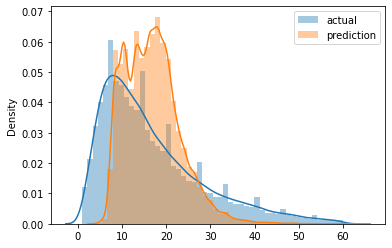

In [35]:
# Visualization of prediction
sns.distplot(y_train, label="actual")
sns.distplot(y_pred, label="prediction")
plt.legend()

Prediction is slightly mismatched from actual but it follows similar pattern of train data.

## Put everything on preparing dataframe in a function

In [51]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df["lpep_dropoff_datetime"] =  pd.to_datetime(df["lpep_dropoff_datetime"])
        df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)
    else:
        print("Only .csv | parquet files are allowed")
        return
    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df["duration"] = df.duration.apply(lambda x: x.total_seconds() / 60)    # convert into minutes
    df = df[(df.duration >=1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df

In [52]:
# Initalizing train and validation DataFrame:
df_train = read_dataframe("./green_tripdata_2021-01.parquet")
df_val = read_dataframe("./green_tripdata_2021-02.parquet")
print(df_train.shape)
print(df_val.shape)

(73908, 21)
(61921, 21)


In [53]:
# Processing the data:
df_train["PU_DO"] = df_train["PULocationID"] + '_' + df_train['DOLocationID']
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [59]:
# Initialize one hot encoding in a function:
def one_hot_encoding(df_train, df_val, categorical, numerical):
    '''
    categorical: List of categorical col names
    numerical: List of numerical col names
    '''
    dict_v = DictVectorizer()
    train_dicts = df_train[categorical + numerical].to_dict(orient="records") # initialize dict
    X_train = dict_v.fit_transform(train_dicts)
    val_dicts = df_val[categorical + numerical].to_dict(orient="records")
    X_val = dict_v.transform(val_dicts)
    target = "duration"
    y_train = df_train[target].values
    y_val = df_val[target].values
    return dict_v, X_train, X_val, y_train, y_val

In [60]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]
dv, X_train, X_val, y_train, y_val = one_hot_encoding(df_train, df_val, categorical, numerical)

In [61]:
# Training Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False)) # print RMSE

7.479582272234666


In [65]:
# Save the train model
if not os.path.isdir("models"):
    os.makedirs("./models")
with open("models/lin_reg.pickle", "wb") as f:
    pickle.dump((dv, lr), f)

In [67]:
# Training Lasso Regression
lr = Lasso(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print(mean_squared_error(y_val, y_pred, squared=False)) # Print RMSE

11.167275941179728
